In [1]:
%config IPCompleter.greedy=True
#Press Shift + Tab to trigger autocomplete.

In [52]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
!python -m pip install --user timm

In [2]:
!pip install -q transformers

In [87]:
pip install --upgrade transformers

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-multimodal 1.1.1 requires accelerate<0.22.0,>=0.21.0, but you have accelerate 0.32.1 which is incompatible.
autogluon-multimodal 1.1.1 requires jso

In [2]:
pip install --upgrade timm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#**Import Libraries :**
#@title Import and Install Libraries { vertical-output: true, display-mode: "form" }
import numpy as np
from numpy import vstack
from datasets import load_dataset
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
import timm
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import (
    Compose,
    Normalize,
    ToTensor,
    Resize
)
from transformers import ViTModel
from einops import rearrange
from timm import create_model

import tensorflow as tf
import os
import PIL
from PIL import Image
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from transformers import AutoModelForImageClassification

np.random.seed(0)
torch.manual_seed(0)

print("All libraries are imported successfully")

/arf/sw/apps/truba-ai/cpu/miniforge3-2024/envs/cpu-2024.0/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/arf/sw/apps/truba-ai/cpu/miniforge3-2024/envs/cpu-2024.0/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-11-17 19:36:30.777850: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 19:36:30.805651: I tensorflow/core/platform/cpu_feat

All libraries are imported successfully


In [4]:
# @title Defining Paths and Parameters
class Path :
  def __init__(self, choice) :
    name = choice # choice = "132+800" | choice = "50+150" | choice = "206+200"

    self.training_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/" + name
    self.validation_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Validation_dataset/" + name
    self.test_dataset = "/arf/home/edilek/KMO_Sample_Dataset/Test_dataset/" + name

    self.model_name = "Hybrid_VGG16_ViT"
    self.model_path =  "/arf/home/edilek/ViT_FT_Output/Models/"+ name + "/" + self.model_name + ".pth"
    self.w_h = 224

print("Paths and Parameters are defined successfully")

Paths and Parameters are defined successfully


**Choice of Dataset and Parameters:**

In [5]:
#@title Choice of Dataset and Parameters { display-mode: "form" }
choice = "132+800" #@param ["132+800", "50+150", "206+200"]
paths = Path(choice)

w_h               = paths.w_h
model_name        = paths.model_name
model_path        = paths.model_path
#print(model_path)

array([[ 14,  17,  17, ...,  16,  18,  17],
       [ 19,  14,  16, ...,  19,  12,  14],
       [ 15, 169,  55, ...,  51,  19,  17],
       ...,
       [ 88,  88,  85, ...,  76,  75,  73],
       [ 88,  86,  84, ...,  76,  75,  73],
       [ 87,  85,  85, ...,  76,  76,  75]], dtype=uint8)

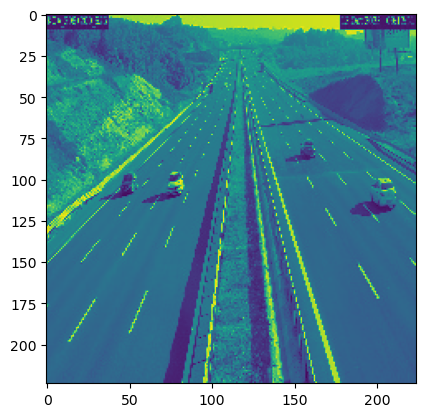

In [6]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/206+200/Normal/000010.jpg")
plt.imshow(img)

import cv2 
# read image
img = cv2.imread('/arf/home/edilek/KMO_Sample_Dataset/Training_dataset/206+200/Normal/000010.jpg', cv2.IMREAD_UNCHANGED)
img

In [7]:
#@title Create Output Folders

def create_output_folders():
   
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/"):
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/"):
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/")
      
  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/")

  if not os.path.exists("/arf/home/edilek/ViT_FT_Output/Models/" + choice +"/"): 
      os.makedirs("/arf/home/edilek/ViT_FT_Output/Models/" + choice + "/")

create_output_folders()

len train_set: 12733
len validation_set: 2547
len test_set: 638
dataset_sizes: [12733, 2547, 638]
Dataset ImageFolder
    Number of datapoints: 12733
    Root location: /arf/home/edilek/KMO_Sample_Dataset/Training_dataset/132+800
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
labels: ['Anomaly', 'Normal']
id2label: {0: 'Anomaly', 1: 'Normal'}
label2id: {'Anomaly': 0, 'Normal': 1}
example: (tensor([[[-1.9124, -1.7412, -1.9124,  ..., -1.8097, -1.9980, -1.7925],
         [-1.7240, -1.9638, -1.6555,  ..., -1.9124, -1.7754, -1.8953],
         [-1.7412,  0.6734, -1.2274,  ...,  2.1119,  0.7248, -1.6727],
         ...,
         [-0.0287, -0.0287, -0.0458,  ..., -0.7650, -0.8849, -0.7993],
         [-0.0287, -0.0287, -0.0458,  ..., -1.1589, -0.6109, -1.0048],
         [-0.0116, -0.0287, -0.0458,  ...,  1.6324, -1.0219, -0.8678]],

        [[-1.8256, -1.6506, -1.8256,  ..., -1.7206,

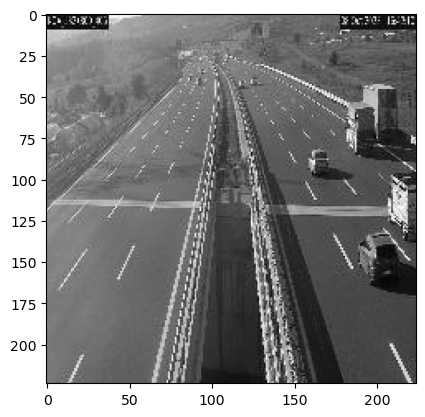

In [9]:
#@title Loading data
transform = transforms.Compose([  transforms.ToTensor(),
                                  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Define normalization parameters (ImageNet mean and std)
                                ])

train_set      = datasets.ImageFolder(paths.training_dataset, transform=transform)
validation_set = datasets.ImageFolder(paths.validation_dataset, transform=transform)
test_set       = datasets.ImageFolder(paths.test_dataset, transform=transform)
dataset_sizes  = [len(train_set), len(validation_set), len(test_set)]    

print("len train_set:", len(train_set))
print("len validation_set:", len(validation_set))
print("len test_set:", len(test_set)) 
print("dataset_sizes:", dataset_sizes)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
valid_loader = DataLoader(validation_set, shuffle=True, batch_size=128)
test_loader  = DataLoader(test_set, shuffle=False, batch_size=128)

print(train_set)
labels = ['Anomaly', 'Normal']
print("labels:", labels)

id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}

print("id2label:", id2label)
print("label2id:", label2id)

example = train_set[0]
print("example:", example)
plt.imshow(example[0].numpy()[0], cmap='gray') 

In [10]:
# Define a function to freeze Vision Transformer layers (optional)
def freeze_vit_layers(model):
    for param in model.vit.parameters():
        param.requires_grad = False

In [59]:
# Python code for Hybrid ViT model which includes a CNN Variant for feature extraction starts from here.

# Helper function to load CNN backbone
def get_cnn_backbone(cnn_variant):
    """
    Retrieves the specified CNN backbone for feature extraction and returns its feature extractor along with the feature dimensionality.
    Initializes a CNN backbone for feature extraction.

    Args:
        cnn_variant (str): The name of the CNN backbone to use.
    
    Returns:
        cnn_features (nn.Sequential): CNN feature extraction layers.
        feature_dim (int): Number of output features from the CNN (Dimensionality of the extracted features).
    """
    # Handle VGG16 backbone
    if cnn_variant == 'vgg16':
        cnn = models.vgg16(pretrained=True)  # Load pre-trained VGG16
        feature_dim = 512  # Output feature size after global pooling
        cnn_features = nn.Sequential(*list(cnn.features))  # Feature extraction layers
    
    # Handle VGG19 backbone
    elif cnn_variant == 'vgg19':
        cnn = models.vgg19(pretrained=True)  # Load pre-trained VGG19
        feature_dim = 512
        cnn_features = nn.Sequential(*list(cnn.features))
    
    # Handle Xception backbone
    elif cnn_variant == 'xception':
        cnn = create_model('xception', pretrained=True)  # Load Xception
        feature_dim = cnn.num_features  # Feature size
        cnn_features = nn.Sequential(*list(cnn.children())[:-1])  # Exclude classification head
    
    # Handle ResNet50 backbone
    elif cnn_variant == 'resnet50':
        cnn = models.resnet50(pretrained=True)  # Load ResNet50
        feature_dim = 2048  # Feature size after global pooling
        cnn_features = nn.Sequential(*list(cnn.children())[:-2])  # Exclude global pooling and FC layer
    
    # Handle EfficientNetB0 backbone
    elif cnn_variant == 'efficientnet_b0':
        cnn = models.efficientnet_b0(pretrained=True)  # Load EfficientNetB0
        feature_dim = 1280
        cnn_features = nn.Sequential(*list(cnn.children())[:-2])
    
    # Handle EfficientNetV2S backbone
    elif cnn_variant == 'efficientnetv2_s':
        cnn = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)  # Pre-trained
        feature_dim = cnn.classifier[1].in_features  # Output features of the classifier
        cnn_features = nn.Sequential(*list(cnn.children())[:-1])  # Remove the classifier

    # Handle MobileNetV3Small backbone
    elif cnn_variant == 'mobilenetv3_small':
        cnn = models.mobilenet_v3_small(pretrained=True)
        feature_dim = cnn.classifier[0].in_features
        cnn_features = nn.Sequential(*list(cnn.children())[:-1])  # Remove classifier

    # Handle DenseNet121 backbone
    elif cnn_variant == 'densenet121':
        cnn = models.densenet121(pretrained=True)
        feature_dim = cnn.classifier.in_features
        cnn_features = nn.Sequential(*list(cnn.features), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)))

    # Handle NASNetMobile backbone
    elif cnn_variant == 'nasnetlarge':
        cnn = timm.create_model('nasnetalarge', pretrained=True, num_classes=0)  # Feature extractor
        feature_dim = cnn.num_features  # NASNetMobile output features
        cnn_features = nn.Sequential(cnn)

    # Handle ConvNeXtTiny backbone
    elif cnn_variant == 'convnext_tiny':
        cnn = create_model('convnext_tiny', pretrained=True, num_classes=0)  # Feature extractor
        feature_dim = cnn.num_features  # ConvNeXtTiny output features
        cnn_features = nn.Sequential(cnn)

    # Handle InceptionV3 backbone
    elif cnn_variant == 'inceptionv3':
        cnn = timm.create_model('inception_v3', pretrained=True, num_classes=0)  # Pre-trained model
        feature_dim = cnn.num_features  # Output features of InceptionV3
        cnn_features = nn.Sequential(cnn)

    else:
        raise ValueError(f"Unknown CNN variant: {cnn_variant}")
    
    return cnn_features, feature_dim

In [60]:
class HybridCNNViT(nn.Module):
    """
    Hybrid model combining CNN feature extraction and a Vision Transformer.
    
    Args:
        cnn_variant (str): Name of the CNN model to use for feature extraction.
        num_classes (int): Number of output classes for classification.
        transformer_dim (int): Embedding size for the Vision Transformer. Default is 768.
    """
    def __init__(self, cnn_variant, num_classes, transformer_dim=768):
        super(HybridCNNViT, self).__init__()
        
        # Initialize the CNN backbone
        # Extracts spatial features from images (like edges, textures)
        self.cnn_features, feature_dim = get_cnn_backbone(cnn_variant)
        
        # Initialize the pre-trained Vision Transformer
        # Processes global relationships in the image
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Linear layer to project CNN output to the transformer dimension
        # Ensures CNN features and ViT embeddings are in the same space
        self.cnn_proj = nn.Linear(feature_dim, transformer_dim)
        
        # Fully connected classification head
        # Takes combined CNN and ViT features for final classification
        self.fc = nn.Linear(transformer_dim * 2, num_classes)

    def forward(self, x):
        """
        Forward pass of the hybrid model.
        
        Args:
            x (torch.Tensor): Input image tensor of shape (B, C, H, W).
        
        Returns:
            torch.Tensor: Class logits of shape (B, num_classes).
        """    
        # Step 1: Pass the input image through the CNN backbone
        # This extracts spatial features (B, C, H, W)
        cnn_out = self.cnn_features(x)
        
        # Step 2: Global average pooling to reduce spatial dimensions
        # Output shape: (B, C)
        if cnn_out.dim() == 4:  # Check if spatial dimensions exist
            cnn_out = torch.mean(cnn_out, dim=[2, 3])  # Pool over H and W
        elif cnn_out.dim() == 2:  # Already pooled (e.g., for some CNNs)
            pass
        else:
            raise ValueError(f"Unexpected CNN output dimensions: {cnn_out.shape}")
        
        # Step 3: Project CNN features to the transformer embedding dimension
        # Output shape: (B, transformer_dim)
        cnn_out = self.cnn_proj(cnn_out)

        # Step 4: Pass the input image through the Vision Transformer
        # ViT processes the input and extracts global relationships
        # Output shape: (B, seq_len, transformer_dim)
        vit_output = self.vit(pixel_values=x).last_hidden_state
        
        # Extract the [CLS] token embedding for classification
        # Shape: (B, transformer_dim)
        vit_cls_token = vit_output[:, 0]

        # Step 5: Concatenate CNN and ViT features
        # Combined feature shape: (B, transformer_dim * 2)
        combined_features = torch.cat([cnn_out, vit_cls_token], dim=1)

        # Step 6: Pass the combined features through the classification head
        # Output shape: (B, num_classes)
        x = self.fc(combined_features)
        
        return x

In [61]:
# Hyperparameters
# cnn_variant = 'vgg16', 'vgg19', 'resnet50', 'xception', 'inceptionv3', 'efficientnet_b0', 'efficientnetv2_s', 'mobilenet_v3_small', 'densenet121', 'nasnetlarge', 'convnext_tiny'
cnn_variant = 'inceptionv3'  # Change to your desired CNN variant
num_classes = 2  # Adjust based on your dataset
learning_rate = 1e-4
batch_size = 128
N_EPOCHS = 1

In [62]:
# Initialize the model
model = HybridCNNViT(cnn_variant=cnn_variant, num_classes=num_classes)

model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

In [63]:
# Freeze ViT layers (optional)
freeze_vit_layers(model)

In [64]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [65]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = model.to(device)

In [66]:
def main():
    # Training loop
    train_acc_values, val_acc_values, train_loss_values, val_loss_values = list(), list(), list(), list()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_time = 0.0
    valid_time = 0.0
    test_time = 0.0
    
    for epoch in trange(N_EPOCHS, desc="Training"):
        ###########################################################################
        print("Training epoch:", epoch+1)
        t0 = time.time()
        
        model.train(True)

        train_accuracy = 0.0    
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            #print("batch.shape:", batch[0].shape)
            x, y = batch            
            x, y = x.to(device), y.to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            y_hat = model(x)

            #print("x.shape:", x.shape, " y.shape:", y.shape, "y_hat shape :", y_hat.shape)
            # Compute the loss and its gradients
            loss = criterion(y_hat, y)  
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            train_loss += loss.detach().cpu().item() / len(train_loader)

            acc = (y_hat.argmax(dim=1) == y).float().mean()
            train_accuracy += acc / len(train_loader)
            
        t1 = round(time.time() - t0)
        train_time = train_time + t1
        ###########################################################################
        
        print("Validating epoch:", epoch+1)
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        t0 = time.time()
        
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_accuracy = 0.0
            val_loss = 0.0
            
            for batch in tqdm(valid_loader, desc="Validating"):
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                
                loss = criterion(y_hat, y)            
                val_loss += loss.detach().cpu().item() / len(valid_loader)

                acc = (y_hat.argmax(dim=1) == y).float().mean()
                val_accuracy += acc / len(valid_loader)

        t1 = round(time.time() - t0)
        valid_time = valid_time + t1
        ###########################################################################
        # Store train/validation acc/loss history 
        
        train_acc_values.append(torch.round(train_accuracy, decimals=4))
        val_acc_values.append(torch.round(val_accuracy, decimals=4))
        
        train_loss_values.append(torch.round(torch.as_tensor(train_loss), decimals=4))
        val_loss_values.append(torch.round(torch.as_tensor(val_loss), decimals=4))

        # Deep copy the model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
                
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f} best_acc: {best_acc:.4f}")
        print(f"Epoch : {epoch+1} - loss : {train_loss:.4f} - acc: {train_accuracy:.4f} - val_loss : {val_loss:.4f} - val_acc: {val_accuracy:.4f}\n")
        ###########################################################################

    # Save the model's state
    torch.save(best_model_wts, model_path)

    #############################################################################
    # Draw Training/Validation Accuracy Graph
    acc     = train_acc_values
    val_acc = val_acc_values
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_acc_values).cpu().numpy(), label='Training Accuracy')  
    plt.plot(torch.stack(val_acc_values).cpu().numpy(), label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.ylim([0, 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Accuracy/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

    # Draw Training/Validation Loss Graph
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 10))
    plt.plot(torch.stack(train_loss_values).cpu().numpy(), label='Training Loss')
    plt.plot(torch.stack(val_loss_values).cpu().numpy(), label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.ylim([0, 1])
    plt.legend(loc='lower left')
    plt.title(model_name)
    plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Loss/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
    plt.show()
    ###############################################################################

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        predictions, actuals = list(), list()
        
        for batch in tqdm(test_loader, desc="Testing"):
            t0 = time.time()
            
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)

            t1 = round(time.time() - t0)
            test_time = test_time + t1
            
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)
            
            # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item() 
            total += len(x)

            #print("x.shape:", x.shape, "y.shape:", y.shape, " y_hat.shape:", y_hat.shape)
            #print("y[0]:", y[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])
            
            ############ Calculate accuracy in a different way ###########
            
            #print("yhat shape1:", y_hat.shape)
            # retrieve numpy array
            y_hat = y_hat.detach().cpu().numpy()
            #print("yhat shape2:", y_hat.shape)
            
            actual = y.detach().cpu().numpy()
            actual = actual.reshape((len(actual), 1))                       
            
            # store y_hat and actual values
            p = np.argmax(y_hat, axis=1).reshape((len(y_hat), 1)) # tahmin edilen sinif = en yuksek degere sahip sutun indeksi
            #print("actual[0]:", actual[0], " y_hat[0,0]:", y_hat[0,0], " y_hat[0,1]:", y_hat[0,1])            
            predictions.append(p) 
            actuals.append(actual)    
            #print("actual.shape:", actual.shape, " y_hat.shape:", y_hat.shape, " prediction.shape:", p.shape)
            #print("actual:", actual," prediction:", p)
            ###########################################################
        
        print(f"Test loss: {test_loss:.4f} Test accuracy: {correct / total * 100:.2f}%")
        #print(f"Test accuracy: {correct / total * 100:.2f}%")

        ############ Calculate accuracy in a different way ###########
        predictions, actuals = vstack(predictions), vstack(actuals)
        acc = metrics.accuracy_score(actuals, predictions)         
        print(f"Test accuracy 2: {acc * 100:.2f}%")

        print("actuals.shape:", actuals.shape, " predictions.shape:", predictions.shape)
        actuals = tf.squeeze(actuals)
        predictions = tf.squeeze(predictions)
        #########################################################################################################
        print("\n")
        print(f"Training time: {train_time:.4f}s Validation time: {valid_time:.4f}s Test time: {test_time:.4f}s")
        print(f"Training time of a frame: {(train_time/dataset_sizes[0]):.4f}s")
        print(f"Validation time of a frame: {(valid_time/dataset_sizes[1]):.4f}s")
        print(f"Prediction time of a frame: {(test_time/dataset_sizes[2]):.4f}s")
        if test_time > 0 :
            fps = round(dataset_sizes[2]/test_time)
            print(f"fps: {fps}")

        # Calculation of Metrics
        # Accuracy = metrics.accuracy_score(actual, predicted)
        # Precision = metrics.precision_score(actual, predicted)
        # Sensitivity_recall = metrics.recall_score(actual, predicted)
        # Specificity = metrics.recall_score(actual, predicted, pos_label=0)
        # F1_score = metrics.f1_score(actual, predicted)

        #############################################################################
        # Create Confusion Matrix

        TP, FN, FP, TN = confusion_matrix(actuals, predictions).ravel()

        print('\n')
        print('True Positive(TP)  = ', TP)
        print('False Positive(FP) = ', FP)
        print('True Negative(TN)  = ', TN)
        print('False Negative(FN) = ', FN)
        accuracy =  (TP + TN) / (TP + FP + TN + FN)
        precision = TP/(TP + FP)
        recall = TP / (TP + FN)
        F1_score = (2 * precision * recall)/(precision + recall)
        print('Accuracy = {:0.4f}'.format(accuracy), ' Precision = {:0.4f}'.format(precision), ' Recall = {:0.4f}'.format(recall), ' F1 Score = {:0.4f}'.format(F1_score))
        print('\n')  

        cm = tf.math.confusion_matrix(actuals, predictions)
        cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
        plt.figure(figsize=(10, 7))
        sbn.set(font_scale=1.6)
        sbn.heatmap(cm,cmap="YlGnBu",cbar=False, xticklabels=['Anomaly','Normal'], yticklabels=['Anomaly','Normal'], annot=True, fmt='.4f')
        plt.title(model_name)
        plt.xlabel('Predicted',labelpad=10)
        plt.ylabel('Actual',labelpad=10)
        plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/Confusion_Matrix/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################

        #############################################################################
        # Create Classification Report
        from sklearn.metrics import classification_report
        target_names = ['Anomaly','Normal']
        print(classification_report(actuals, predictions, target_names=target_names))
        #############################################################################

        #############################################################################
        # Draw ROC Curve
        fpr,tpr,thresholds = metrics.roc_curve(actuals, predictions)
        auc = metrics.roc_auc_score(actuals, predictions)
        print("AUC = {:0.4f}".format(auc))
        plt.figure(figsize=(10, 7))
        plt.title("Camera No:"+ choice +" ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot(fpr,tpr, label='ROC curve of '+ model_name.upper() +' (AUC = '+  "{:.4f}".format(auc)+')')
        plt.legend(fontsize="xx-small", bbox_to_anchor =(1.0, 0.07), loc='lower right')
        plt.axhline(0, color="black", alpha=0.3)
        plt.axvline(0, color="black", alpha=0.3)
        plt.savefig(("/arf/home/edilek/ViT_FT_Output/Images/" + choice + "/ROC/"+ model_name +'.jpg'), bbox_inches='tight', transparent=True, dpi=300)
        plt.show()
        #############################################################################                      

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch: 1



Epoch 1 in training: 100%|██████████| 100/100 [03:55<00:00,  2.59s/it]
                                                                      

Validating epoch: 1



Training: 100%|██████████| 1/1 [04:17<00:00, 257.77s/it]


Epoch 1/1 loss: 0.0657 best_acc: 0.9938
Epoch : 1 - loss : 0.0657 - acc: 0.9723 - val_loss : 0.0189 - val_acc: 0.9938



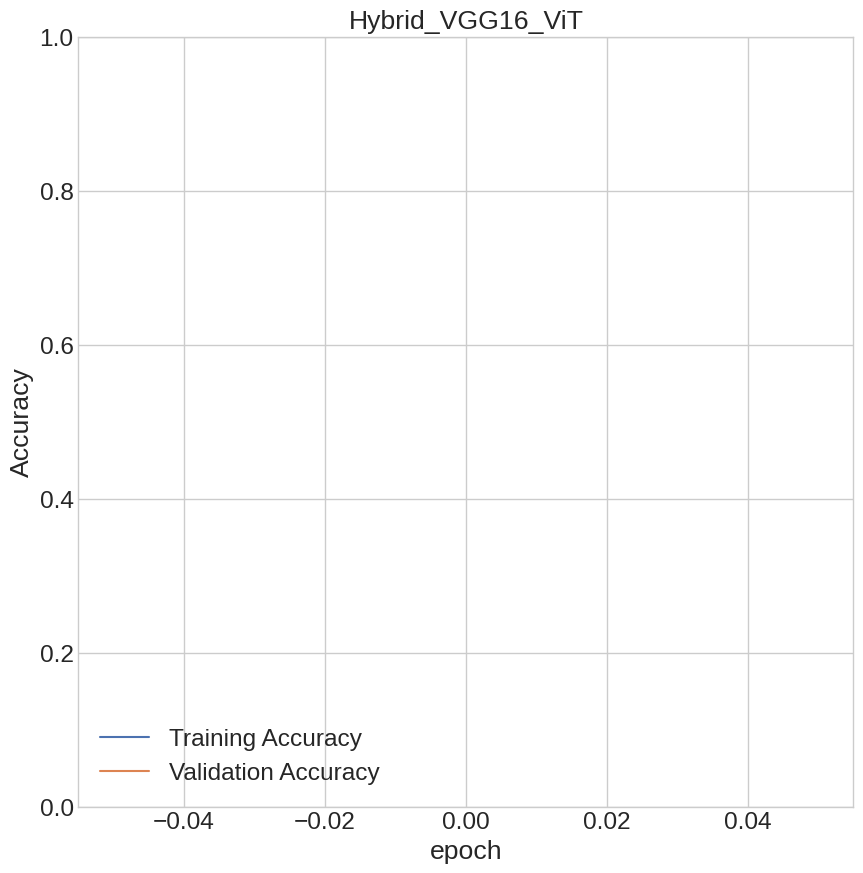

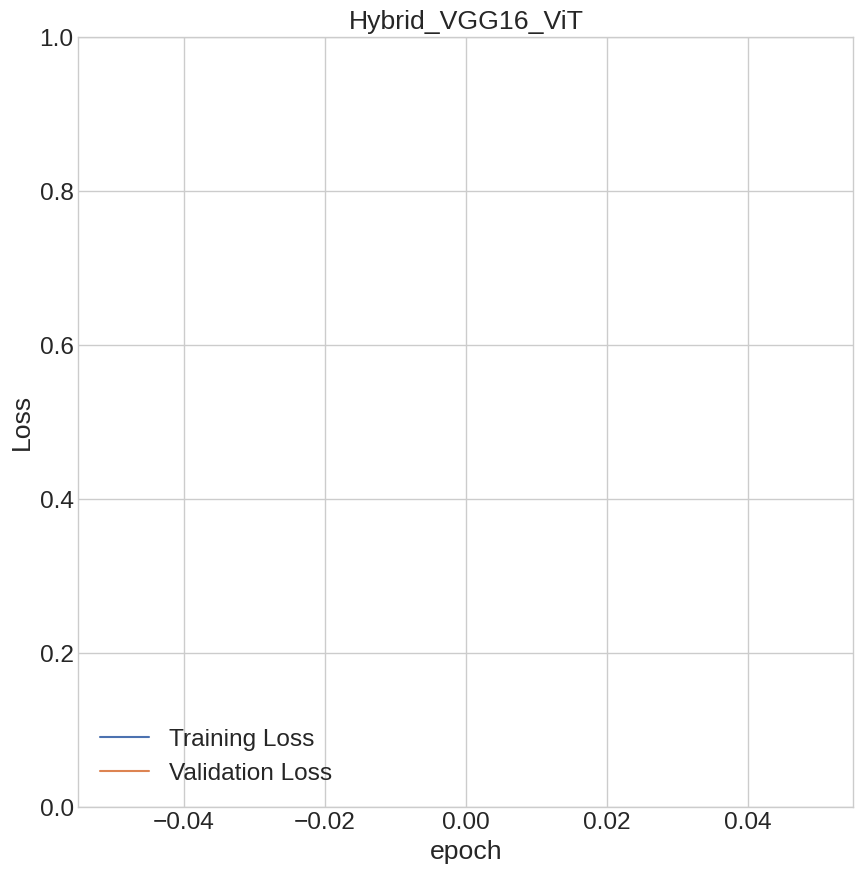

Testing: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Test loss: 0.0107 Test accuracy: 99.53%
Test accuracy 2: 99.53%
actuals.shape: (638, 1)  predictions.shape: (638, 1)


Training time: 236.0000s Validation time: 22.0000s Test time: 5.0000s
Training time of a frame: 0.0185s
Validation time of a frame: 0.0086s
Prediction time of a frame: 0.0078s
fps: 128


True Positive(TP)  =  145
False Positive(FP) =  3
True Negative(TN)  =  490
False Negative(FN) =  0
Accuracy = 0.9953  Precision = 0.9797  Recall = 1.0000  F1 Score = 0.9898




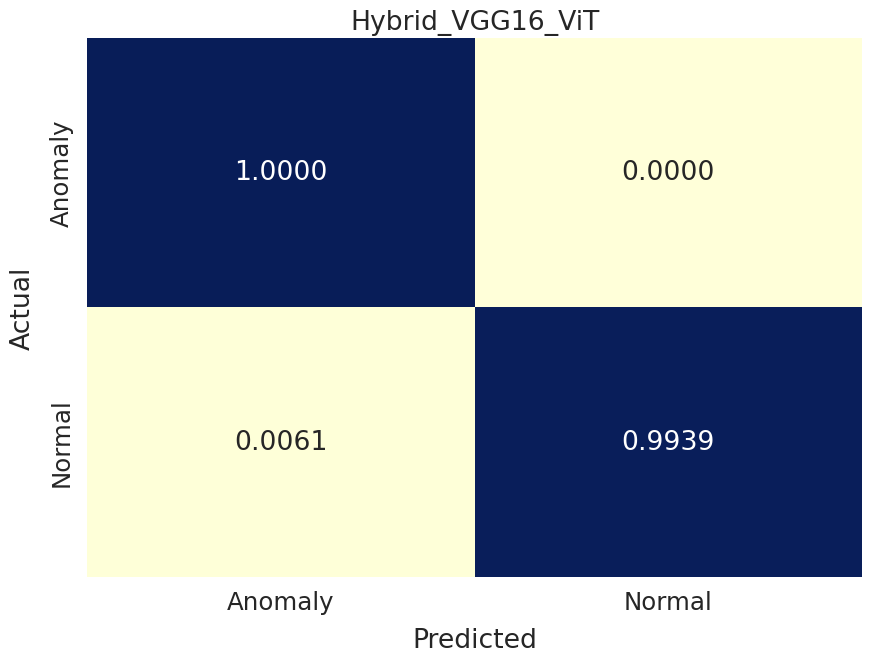

              precision    recall  f1-score   support

     Anomaly       0.98      1.00      0.99       145
      Normal       1.00      0.99      1.00       493

    accuracy                           1.00       638
   macro avg       0.99      1.00      0.99       638
weighted avg       1.00      1.00      1.00       638

AUC = 0.9970


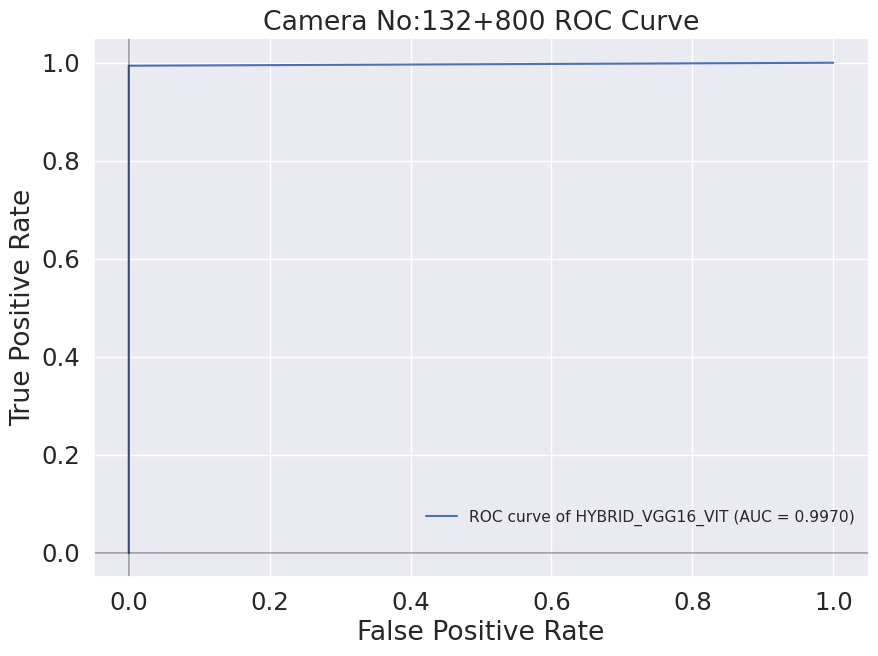

In [67]:
main()